# **Без будущего**

## Колдунство высокого уровня

In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install tensorflow-gpu==2.0

## Библиотеки ставим да дескрипторы указываем

In [0]:
import sklearn
import cv2
import pandas as pd
import numpy as np

In [0]:
descriptors={'surf': cv2.xfeatures2d.SURF_create().detectAndCompute,
             'sift': cv2.xfeatures2d.SIFT_create().detectAndCompute,
             'akaze': cv2.AKAZE_create().detectAndCompute}

## Грузим данные (осторожно, реурсия!)

In [3]:
! git clone https://github.com/tupoylogin/CVPR_Lab_2.git

Cloning into 'CVPR_Lab_2'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 51946 (delta 2), reused 0 (delta 0), pack-reused 51937
Receiving objects: 100% (51946/51946), 299.70 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (51893/51893), done.


In [0]:
import os

basePath = os.path.join(os.curdir,'CVPR_Lab_2')

def load_split(basePath, csvPath):
    
    from sklearn.utils import shuffle
    
    # initialize the list of data and labels
    data = []
    labels = []
 
    # load the contents of the CSV file, remove the first line (since
    # it contains the CSV header), and shuffle the rows (otherwise
    # all examples of a particular class will be in sequential order)
    
    rows_df = pd.read_csv(csvPath)[['ClassId','Path']]
    
    # loop over the rows of the CSV file
    for row in rows_df.values:
        # check to see if we should show a status update
        (label, imagePath) = row[0], row[1]
 
        # derive the full path to the image file and load it
        imagePath = os.path.sep.join([basePath, imagePath])
        image = cv2.imread(imagePath)
         # resize the image to be 64x64 pixels, ignoring aspect ratio,
        image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        # and then perform Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=0.1)
        img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
        #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        # convert the YUV image back to RGB format
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
       
        
        
        # update the list of data and labels, respectively
        data.append(image)
        labels.append(int(label))
 
    # convert the data and labels to NumPy arrays
    data = np.array(data)
    
 
    # return a tuple of the data and labels
    return rows_df, data

In [0]:
train, data = load_split(basePath,os.path.join(basePath, 'Train.csv'))

In [6]:
train.head(5)

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

### 11 шакалов из 10

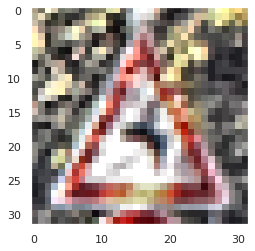

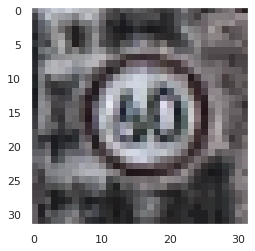

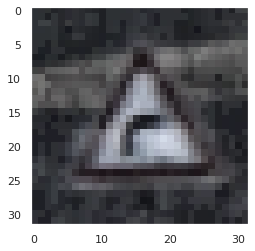

<Figure size 432x288 with 0 Axes>

In [8]:
sns.set()
with sns.axes_style({'axes.grid': False}):
  for idx in np.random.choice(train.ClassId.shape[0],3):
    plt.imshow(data[idx]),plt.show()
    plt.figure(idx+1)

## Сверточная сеть на 31 слой

In [14]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

batch_size = 32
num_classes = train['ClassId'].unique().shape[0]

# The data, split between train and test sets:
print('x_train shape:', data.shape)
print(data.shape[0], 'train samples')
print(test_data.shape[0], 'test samples')

#height, width = data.shape[1:]
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(train['ClassId'].values, num_classes)
y_test = tf.keras.utils.to_categorical(test['ClassId'].values, num_classes)
x_train = data.astype('float32')
x_test = test_data.astype('float32')
x_train /= 255
x_test /= 255
#uncomment for grayscale imgs
#x_train = x_train.reshape((x_train.shape[0], height, width,1))
#x_test = x_test.reshape((x_test.shape[0], height, width,1))
 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train['ClassId']),
                                                 train['ClassId'])

class_weights = dict(enumerate(class_weights))

x_train shape: (39209, 32, 32, 3)
39209 train samples
12630 test samples


In [0]:
K.clear_session()

In [0]:
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Flatten, Dropout, Dense
import tensorflow.keras.backend as K

class MetricsAtTopK:
  def __init__(self, k):
    self.k = k

  def _get_prediction_tensor(self, y_pred):
    """
    Takes y_pred and creates a tensor of same shape with 1 in indices 
    where the values are in top_k
    """
    topk_values, topk_indices = tf.nn.top_k(y_pred, k=self.k, sorted=False, 
                                            name="topk")
    # the topk_indices are along last axis (1). Add indices for axis=0
    ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(self.k), 
                        indexing='ij')
    index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), 
                                                      shape=(-1, 2))
    prediction_tensor = tf.compat.v1.sparse_to_dense(sparse_indices=index_tensor,
                                               output_shape=tf.shape(y_pred),
                                               default_value=0,
                                               sparse_values=1.0,
                                               validate_indices=False
                                               )
    prediction_tensor = tf.cast(prediction_tensor, K.floatx())
    return prediction_tensor

  def true_positives_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    return true_positive

  def false_positives_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c2 = K.sum(prediction_tensor)  # TP + FP
    false_positive = c2 - true_positive
    return false_positive

  def false_negatives_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c3 = K.sum(y_true)  # TP + FN
    false_negative = c3 - true_positive
    return false_negative

  def precision_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c2 = K.sum(prediction_tensor)  # TP + FP
    return true_positive/(c2+K.epsilon())

  def recall_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c3 = K.sum(y_true)  # TP + FN
    return true_positive/(c3+K.epsilon())

  def f1_at_k(self, y_true, y_pred):
    precision = self.precision_at_k(y_true=y_true, y_pred=y_pred)
    recall = self.recall_at_k(y_true=y_true, y_pred=y_pred)
    f1 = (2*precision*recall)/(precision+recall+K.epsilon())
    return f1

metrics = MetricsAtTopK(k=5)

def load_model(x_train, num_classes):

  model = Sequential()
  model.add(Conv2D(8, (5, 5), padding='same', 
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))	

  model.add(Conv2D(16, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(16, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
 
	# softmax classifier
  model.add(Dense(num_classes))
  model.add(Activation("softmax"))

  # initiate Adam optimizer
  opt = Adam(learning_rate=1e-3, decay=1e-3/32)

  # Let's train the model using Adam
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy',
                #tf.keras.metrics.CategoricalAccuracy(),
                metrics.recall_at_k,
                metrics.precision_at_k,
                metrics.f1_at_k])
  
  return model

In [0]:
model = load_model(x_train=x_train, num_classes=num_classes)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

### Пути назад уже нет!

In [29]:
#reducing learning rate if model is on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.2,
                                                         patience=5, 
                                                         min_lr=1e-5)

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
          rotation_range=10,
          zoom_range=0.3,
	        width_shift_range=0.1,
	        height_shift_range=0.1,
	        shear_range=0.15,
	        horizontal_flip=False,
	        vertical_flip=False,
	        fill_mode="nearest")

#datagen.fit(x_train)

H = model.fit_generator(datagen.flow(x_train, y_train,
                                      batch_size=64),
                          epochs=10, 
                          #class_weight=class_weights,
                          steps_per_epoch=x_train.shape[0]//64,
                          validation_data=(x_test, y_test),
                          callbacks=[reduce_lr],verbose=1)

Epoch 1/10
612/612 [==============================] - 68s 111ms/step - loss: 3.0480 - accuracy: 0.2078 - recall_at_k: 0.5197 - precision_at_k: 0.1039 - f1_at_k: 0.1732 - val_loss: 1.7409 - val_accuracy: 0.4136 - val_recall_at_k: 0.8357 - val_precision_at_k: 0.1671 - val_f1_at_k: 0.2786
Epoch 2/10
612/612 [==============================] - 68s 110ms/step - loss: 1.7898 - accuracy: 0.4227 - recall_at_k: 0.8139 - precision_at_k: 0.1628 - f1_at_k: 0.2713 - val_loss: 1.3442 - val_accuracy: 0.5384 - val_recall_at_k: 0.9009 - val_precision_at_k: 0.1802 - val_f1_at_k: 0.3003
Epoch 3/10
612/612 [==============================] - 68s 110ms/step - loss: 1.3500 - accuracy: 0.5532 - recall_at_k: 0.9019 - precision_at_k: 0.1804 - f1_at_k: 0.3006 - val_loss: 1.0766 - val_accuracy: 0.6311 - val_recall_at_k: 0.9394 - val_precision_at_k: 0.1879 - val_f1_at_k: 0.3131
Epoch 4/10
612/612 [==============================] - 67s 110ms/step - loss: 1.0804 - accuracy: 0.6470 - recall_at_k: 0.9375 - precision_at

In [30]:
# Score trained model.
y_pred = model.predict(x_test,batch_size=batch_size)
print(classification_report(np.argmax(y_test,axis=-1),
	                          np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.30      0.90      0.45        60
           1       0.96      0.82      0.89       720
           2       0.89      0.72      0.80       750
           3       0.58      0.92      0.71       450
           4       0.94      0.84      0.89       660
           5       0.70      0.69      0.70       630
           6       0.94      0.87      0.90       150
           7       0.98      0.76      0.86       450
           8       0.83      0.86      0.85       450
           9       0.93      0.87      0.90       480
          10       0.83      0.99      0.91       660
          11       0.77      0.94      0.85       420
          12       0.99      0.94      0.97       690
          13       0.99      0.97      0.98       720
          14       0.81      1.00      0.90       270
          15       0.99      0.70      0.82       210
          16       0.90      0.91      0.91       150
          17       0.95    

### Теперь показываем сети веса каждого класса для улучшения recall

In [31]:
H1 = model.fit_generator(datagen.flow(x_train, y_train,
                                      batch_size=64),
                          epochs=20, 
                          class_weight=class_weights,
                          steps_per_epoch=x_train.shape[0]//64,
                          validation_data=(x_test, y_test),
                          callbacks=[reduce_lr],verbose=1)

Epoch 1/20
612/612 [==============================] - 67s 110ms/step - loss: 0.6912 - accuracy: 0.8073 - recall_at_k: 0.9785 - precision_at_k: 0.1957 - f1_at_k: 0.3262 - val_loss: 0.4863 - val_accuracy: 0.8457 - val_recall_at_k: 0.9838 - val_precision_at_k: 0.1968 - val_f1_at_k: 0.3279
Epoch 2/20
612/612 [==============================] - 68s 111ms/step - loss: 0.5941 - accuracy: 0.8188 - recall_at_k: 0.9794 - precision_at_k: 0.1959 - f1_at_k: 0.3265 - val_loss: 0.7396 - val_accuracy: 0.7892 - val_recall_at_k: 0.9689 - val_precision_at_k: 0.1938 - val_f1_at_k: 0.3230
Epoch 3/20
612/612 [==============================] - 68s 111ms/step - loss: 0.5581 - accuracy: 0.8279 - recall_at_k: 0.9818 - precision_at_k: 0.1964 - f1_at_k: 0.3273 - val_loss: 0.3822 - val_accuracy: 0.8788 - val_recall_at_k: 0.9886 - val_precision_at_k: 0.1977 - val_f1_at_k: 0.3295
Epoch 4/20
612/612 [==============================] - 68s 111ms/step - loss: 0.5122 - accuracy: 0.8364 - recall_at_k: 0.9832 - precision_at

In [35]:
# Score trained model.
y_pred = model.predict(x_test,batch_size=batch_size)
print(classification_report(np.argmax(y_test,axis=-1),
	                          np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82        60
           1       0.98      0.87      0.92       720
           2       0.81      0.95      0.88       750
           3       0.94      0.86      0.90       450
           4       0.99      0.94      0.97       660
           5       0.83      0.85      0.84       630
           6       0.95      0.97      0.96       150
           7       0.93      0.94      0.93       450
           8       0.89      0.92      0.91       450
           9       1.00      0.96      0.98       480
          10       0.99      0.96      0.98       660
          11       0.96      0.87      0.91       420
          12       0.98      0.95      0.96       690
          13       0.99      0.98      0.99       720
          14       1.00      0.99      0.99       270
          15       0.93      0.96      0.95       210
          16       0.91      0.99      0.95       150
          17       1.00    

### Да свершится предначертанное (на графике)

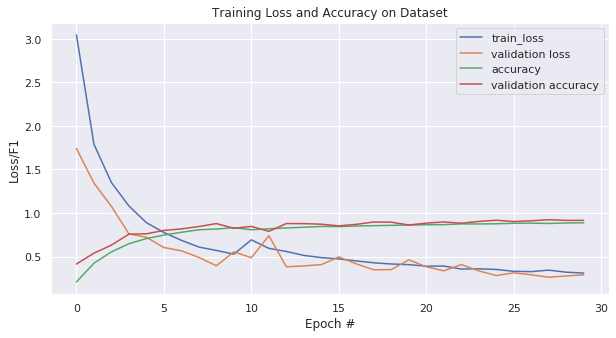

In [36]:
%matplotlib inline

epochs = np.arange(len(H.epoch)+len(H1.epoch))
history = dict()
for key in H.history.keys():
  history[key]=np.concatenate((H.history[key], H1.history[key]))

sns.set()
plt.figure(figsize=(10,5))
plt.plot(epochs, history["loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="validation loss")
plt.plot(epochs, history["accuracy"], label="accuracy")
plt.plot(epochs, history["val_accuracy"], label="validation accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/F1")
plt.legend(loc="upper right")

### **Выводы:** Loss снижен почти до нуля за 30 эпох. Сеть даёт очень хорошие показатели по всем метрикам.

## Сеть с встроенным дескриптором (Dumb MLP + Descriptor Augmentation)

In [0]:
from tensorflow.keras.layers import Lambda
import imgaug as ia
import imgaug.augmenters as iaa

def load_desc_model(height, num_classes):
  
  model = Sequential()
  model.add(Dense(64,input_shape=(height,)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Dense(64))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(256))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
 
	# softmax classifier
  model.add(Dense(num_classes))
  model.add(Activation("softmax"))

  # initiate Adam optimizer
  opt = Adam(learning_rate=1e-3, decay=1e-3/32)

  # Let's train the model using Adam
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
                #tf.keras.metrics.CategoricalAccuracy(),
                
  
  return model


In [160]:
height = 256
model_desc = load_desc_model(height=height,
                             num_classes=num_classes)
model_desc.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_64 (Activation)   (None, 64)                0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 64)                256       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_65 (Activation)   (None, 64)                0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 64)                256       
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)              

### Воспользуемся тренировкой на бэтчах, которые будем аугментировать и получать ключевые точки "на лету"

In [0]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

### Ключевые точки и вычисление дескрипторов берем cледующим образом

In [0]:
def get_key_pts(algorithm,img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gray*=255
    gray=gray.astype('uint8')
    _, descr = algorithm(gray,None)
    return descr.flatten().astype('float32')

def to_same_dims(array, dim):
  kp = np.zeros([len(array),dim])
  for i,j in enumerate(array):
      if len(j)>dim:
        kp[i][0:dim] = j[0:dim]
      else:
        kp[i][0:len(j)] = j
  return kp

In [0]:
def keypoint_generator(features, labels, batch_size, crop, algorithm):
  batch_features = []
  batch_labels = []
  while True:
    indexes = np.random.choice(features.shape[0], batch_size)
    img_batch = [features[i] for i in indexes]
    images_aug = seq(images=img_batch)
    batch_features = [get_key_pts(algorithm, img)/255.0
                        for img in images_aug]
    batch_features = to_same_dims(batch_features, crop)
    batch_labels = np.array([labels[i] for i in indexes])
    yield batch_features, batch_labels

### Наш выбор дескриптора - в пользу SIFT. SURF и AKAZE не справился с большинством тренировочного датасета

In [0]:
x_test_desc = []

for img in x_test:
  des = get_key_pts(descriptors['sift'], img)
  des/=255.0
  x_test_desc.append(des)

x_test_desc = to_same_dims(x_test_desc, 256)

In [161]:
H_des = model_desc.fit_generator(keypoint_generator(x_train, y_train,
                                      batch_size=64, crop=256,
                                      algorithm=descriptors['sift']),
                          epochs=20, 
                          class_weight=class_weights,
                          steps_per_epoch=x_train.shape[0]//64,
                          validation_data=(x_test_desc, y_test),
                          callbacks=[reduce_lr],verbose=1)

Epoch 1/20
612/612 [==============================] - 125s 204ms/step - loss: 4.3931 - accuracy: 0.0219 - val_loss: 3.8038 - val_accuracy: 0.0205
Epoch 2/20
612/612 [==============================] - 123s 201ms/step - loss: 3.8582 - accuracy: 0.0240 - val_loss: 3.7017 - val_accuracy: 0.0330
Epoch 3/20
612/612 [==============================] - 123s 201ms/step - loss: 3.7316 - accuracy: 0.0280 - val_loss: 3.6885 - val_accuracy: 0.0255
Epoch 4/20
612/612 [==============================] - 122s 200ms/step - loss: 3.7079 - accuracy: 0.0306 - val_loss: 3.6493 - val_accuracy: 0.0353
Epoch 5/20
612/612 [==============================] - 122s 200ms/step - loss: 3.6116 - accuracy: 0.0335 - val_loss: 3.5894 - val_accuracy: 0.0447
Epoch 6/20
612/612 [==============================] - 122s 199ms/step - loss: 3.5800 - accuracy: 0.0375 - val_loss: 3.5974 - val_accuracy: 0.0357
Epoch 7/20
612/612 [==============================] - 121s 198ms/step - loss: 3.5367 - accuracy: 0.0430 - val_loss: 3.6140 -

In [164]:
y_pred = model_desc.predict(x_test_desc,batch_size=batch_size)
print(classification_report(np.argmax(y_test,axis=-1),
	                          np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.15      0.15      0.15       720
           2       0.28      0.02      0.04       750
           3       0.00      0.00      0.00       450
           4       0.13      0.06      0.08       660
           5       0.21      0.07      0.11       630
           6       0.32      0.44      0.37       150
           7       0.10      0.05      0.06       450
           8       0.09      0.02      0.03       450
           9       0.09      0.03      0.05       480
          10       1.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.07      0.02      0.03       690
          13       0.01      0.00      0.00       720
          14       0.11      0.13      0.12       270
          15       0.07      0.24      0.11       210
          16       0.08      0.11      0.09       150
          17       0.05    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Изобразим на графике изменения метрик

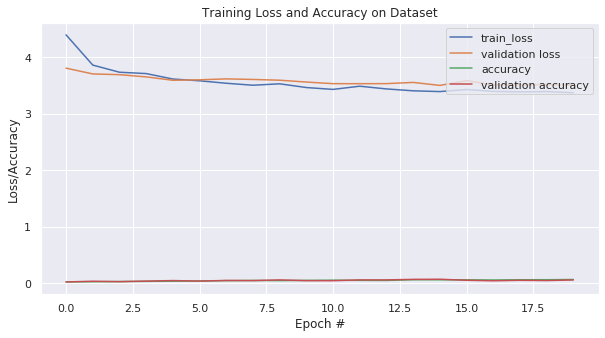

In [165]:
sns.set()
epochs = np.arange(20)
plt.figure(figsize=(10,5))
plt.plot(epochs, H_des.history["loss"], label="train_loss")
plt.plot(epochs, H_des.history["val_loss"], label="validation loss")
plt.plot(epochs, H_des.history["accuracy"], label="accuracy")
plt.plot(epochs, H_des.history["val_accuracy"], label="validation accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### **Выводы:** выражаясь словами классика: "Это фиаско, братан!". Сеть-дескриптор обучается значительно медленнее, чем сверточная сеть, достигает худших показателей метрик за равное количество эпох.